In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy import ndimage
from scipy.interpolate import griddata
import os

import TileUtility as TU

%matplotlib notebook

In [21]:
HT = TU.HalfTiles(TU.FullTiles())

In [64]:
# based on code from MP1 utils.py
def prompt_eye_selection(image):
    fig = plt.figure()
    plt.imshow(image, cmap='gray')
    fig.set_label('Click on corners of game board')
    plt.axis('off')
    xs = []
    ys = []
    clicked = np.zeros((4, 2), dtype=np.float32)

    # Define a callback function that will update the textarea
    def onmousedown(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)

        plt.plot(xs, ys, 'r-+')

    def onmouseup(event):
        if(len(xs) >= 4):
            plt.plot(xs ++ xs[0], ys ++ ys[0], 'r-+')
            plt.close(fig)

    def onclose(event):
        clicked[:, 0] = xs
        clicked[:, 1] = ys
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', onmousedown)
    fig.canvas.mpl_connect('button_release_event', onmouseup)
    fig.canvas.mpl_connect('close_event', onclose)

    return clicked

<IPython.core.display.Javascript object>


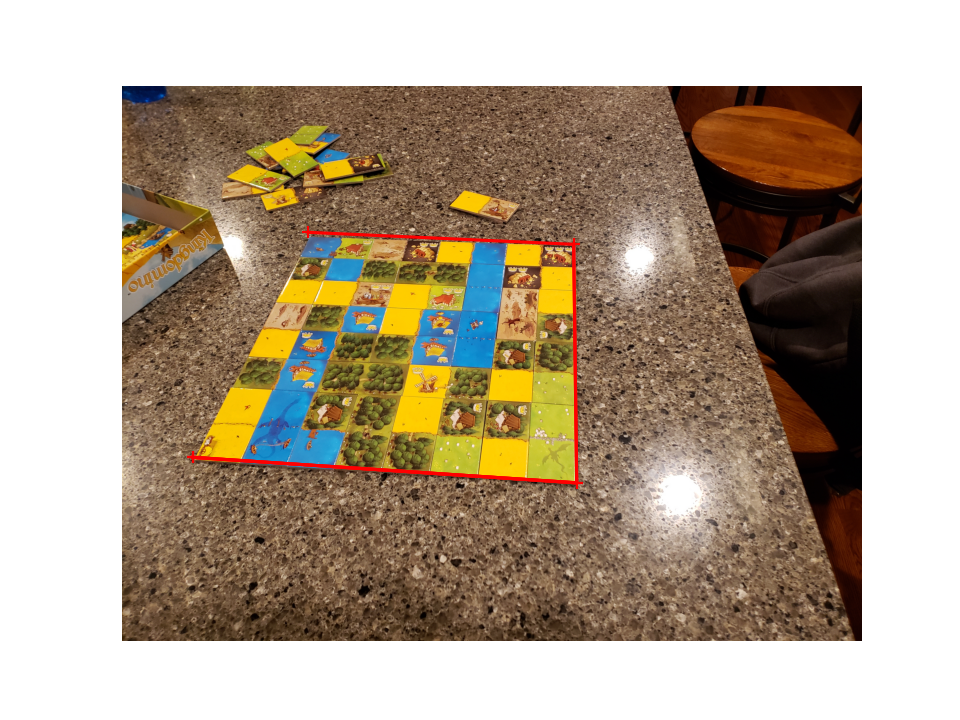

In [81]:
img = cv2.cvtColor(cv2.imread("validation/20201123_163235.jpg"), cv2.COLOR_BGR2RGB)
points = prompt_eye_selection(img)

In [87]:
### override
#points = np.array([[925, 2156], [878, 1648], [1914, 1503], [2295, 1938]])
#points = np.array([[419, 1913], [920, 912], [2179, 890], [2219, 1946]])
#points = np.array([[1446, 1595], [2686, 1626], [2530, 1044], [1639, 1027]])
points = np.array([[ 382.88632, 2022.744  ],
       [2477.432  , 2161.835  ],
       [2461.068  ,  870.9258 ],
       [1032.8863 ,  815.47125]])

<IPython.core.display.Javascript object>


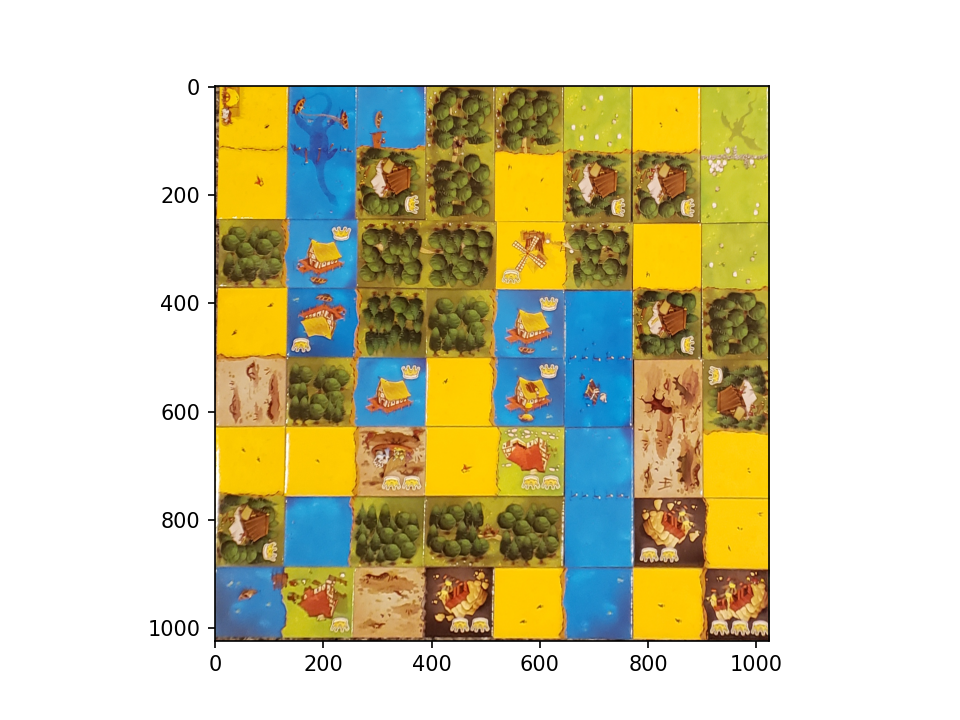

In [88]:
tile_res = 128
H = 8
W = 8
dst = np.array([[0, 0], [H*tile_res - 1, 0], [H*tile_res - 1, W*tile_res - 1], [0, W*tile_res - 1]], dtype="float32")
src = np.array([[s[0],s[1]] for s in points], dtype="float32")

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(img, M, (H*tile_res, W*tile_res))
plt.figure()
plt.imshow(warped)

In [89]:
terrain = np.zeros((W,H))
crowns = np.zeros((W,H))
for i in range(W):
    for j in range(H):
        crop = warped[i*tile_res:(i+1)*tile_res, j*tile_res:(j+1)*tile_res]
        terrain[i, j] = HT.predictTerrain(crop)
        crowns[i, j] = HT.predictCrowns(crop)
        
print(terrain)

[[0. 2. 2. 1. 1. 3. 0. 3.]
 [0. 2. 1. 1. 0. 1. 1. 3.]
 [1. 2. 1. 1. 0. 1. 0. 3.]
 [0. 2. 1. 1. 2. 2. 1. 1.]
 [4. 1. 2. 0. 2. 2. 4. 1.]
 [0. 0. 4. 0. 3. 2. 4. 0.]
 [1. 2. 1. 1. 1. 2. 5. 0.]
 [2. 3. 4. 5. 0. 2. 0. 5.]]


In [90]:
print(crowns)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 2. 0. 2. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 2. 0. 0. 0. 3.]]


In [91]:
manual_corrections = [
    {"coord": (6, 6), "terrain": 5, "crowns": 2}
]

import time;
ts = str(int(time.time()))
print(int(ts))

for idx, C in enumerate(manual_corrections):
    i, j = C["coord"]
    crop = warped[i*tile_res:(i+1)*tile_res, j*tile_res:(j+1)*tile_res]    
    title = "guess is {0}/{1} but you corrected to {2}/{3}".format(
        terrain[i, j], crowns[i, j], C["terrain"], C["crowns"]
    )
    
    name = "training/" + ts + "_" + str(idx) + "_" + \
        str(C["terrain"]) + "_" + \
        str(C["crowns"]) + ".png"
    print(name)
    crop2 = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)
    cv2.imwrite(name, crop2)
#    plt.figure()
#    plt.title(title)
#    plt.imshow(crop)


1606180337
training/1606180337_0_5_2.png
